In [4]:
import os
from os.path import join

import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_pickle("data/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


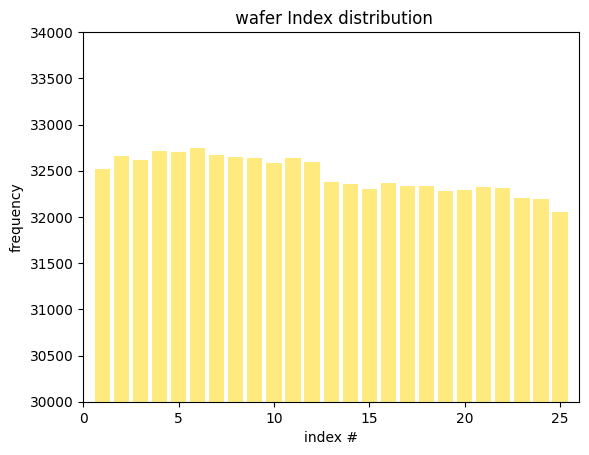

In [5]:
# 웨이퍼 인덱스
uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()


In [7]:
# 웨이퍼 인덱스는 중요하지 않은 정보이기 때문에 삭제
df = df.drop(['waferIndex'], axis = 1)

KeyError: "['waferIndex'] not found in axis"

In [8]:
def find_dim(x):
    dim0=np.size(x, axis=0)
    dim1=np.size(x, axis=1)
    return dim0,dim1

df['waferMapDim'] = df.waferMap.apply(find_dim)
df.sample(10)
# 웨이퍼 dimension 제각각

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
89188,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",939.0,lot6390,[],[],"(39, 31)"
136971,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1801.0,lot8915,[],[],"(56, 41)"
219862,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2003.0,lot13904,[],[],"(51, 50)"
89101,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,...",939.0,lot6373,[],[],"(39, 31)"
807268,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",1060.0,lot47370,[[Test]],[[Loc]],"(41, 33)"
95828,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6275.0,lot6741,[],[],"(92, 87)"
131796,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3532.0,lot8624,[],[],"(64, 71)"
531376,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",710.0,lot33260,[],[],"(32, 29)"
457276,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2,...",515.0,lot28169,[],[],"(25, 27)"
405943,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,...",1187.0,lot24270,[],[],"(51, 30)"


In [9]:
# 26x26 웨이퍼 load

sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])


In [10]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

# check dimension
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


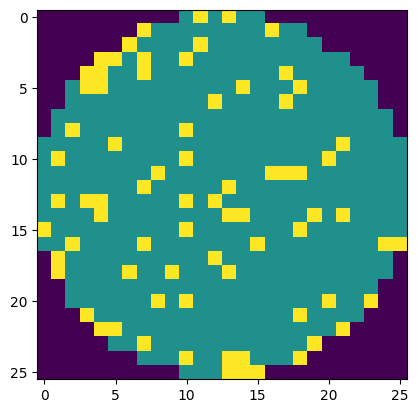

Faulty case : ['none'] 


In [14]:
# plot 1st data
plt.imshow(x[1000])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[1000]))

In [15]:
# 2D Convolution Autoencoder 사용하기 위해 차원 변경
x = x.reshape((-1, 26, 26, 1))

In [17]:
# 라벨별 데이터 수 체크

faulty_case = np.unique(y)
print(f'Faulty case list : {faulty_case}')
print("")

for f in faulty_case :
    print(f'{f} : {len(y[y==f])}')

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [18]:
# 0 -> 외의 영역, 1 -> 정상 2 -> 결함
# 정량적 변수들을 각 채널에 따라 원핫인코딩
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [20]:
# Convolutional Autoencoder
# Hyperparameter
epoch=15
batch_size=512

In [21]:
input_shape = (26, 26, 3)
input_tensor = Input(input_shape) 
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

#디코더
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# 디코더 레이어 연결
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer='Adam', loss='mse')

Metal device set to: Apple M1


2022-11-17 15:12:49.951926: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-17 15:12:49.953334: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 26, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 13, 13, 64)       36928     
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 26, 26, 64)       0         
 )                                                               
                                                             

In [23]:
ae.fit(new_x,new_x, batch_size=batch_size, epochs=epoch, verbose=1)

Epoch 1/15


2022-11-17 15:13:48.709084: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-17 15:13:48.968548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 6s 113ms/step - loss: 0.1248
Epoch 2/15
29/29 [==============================] - 3s 98ms/step - loss: 0.0796
Epoch 3/15
29/29 [==============================] - 3s 99ms/step - loss: 0.0597
Epoch 4/15
29/29 [==============================] - 3s 101ms/step - loss: 0.0481
Epoch 5/15
29/29 [==============================] - 3s 99ms/step - loss: 0.0387
Epoch 6/15
29/29 [==============================] - 3s 98ms/step - loss: 0.0306
Epoch 7/15
29/29 [==============================] - 3s 99ms/step - loss: 0.0247
Epoch 8/15
29/29 [==============================] - 3s 99ms/step - loss: 0.0207
Epoch 9/15
29/29 [==============================] - 3s 101ms/step - loss: 0.0179
Epoch 10/15
29/29 [==============================] - 3s 102ms/step - loss: 0.0158
Epoch 11/15
29/29 [==============================] - 3s 99ms/step - loss: 0.0140
Epoch 12/15
29/29 [==============================] - 3s 100ms/step - loss: 0.0125
Epoch 13/15
29/29 [========================

In [24]:
# 오토인코더 모델 층의 일부로 인코더 모델로 만든다 
encoder = models.Model(input_tensor, latent_vector)

#  오토인코더 모델 층의 일부로 디코더 모델을 만든다 
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

# 기존의 결함이 있는 wafer를 엔코딩
encoded_x = encoder.predict(new_x)

# 노이즈 첨가
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

 58/449 [==>...........................] - ETA: 1s

2022-11-17 15:15:22.791572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


449/449 [==============================] - 1s 3ms/step


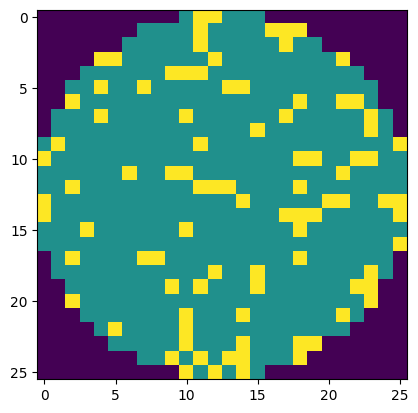

In [25]:
# 기존의 결함 있는 wafer data 시각화
plt.imshow(np.argmax(new_x[3], axis=2))

 25/449 [>.............................] - ETA: 2s

2022-11-17 15:16:10.446352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


449/449 [==============================] - 3s 6ms/step


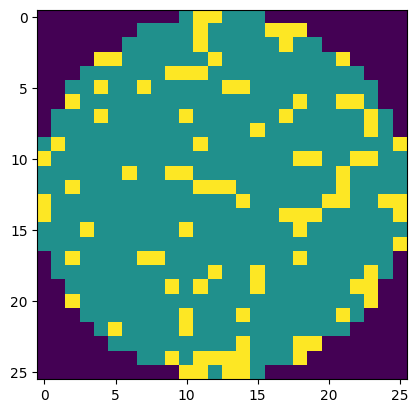

In [26]:
# 노이즈 첨가된 웨이퍼 데이터 시각화
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

In [27]:
# 데이터 증강

def gen_data(wafer, label):
   
    encoded_x = encoder.predict(wafer)
      
    gen_x = np.zeros((1, 26, 26, 3))
        
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    
    gen_y = np.full((len(gen_x), 1), label)       
    return gen_x[1:], gen_y[1:]

In [28]:
# 모든 faulty 데이터를 증강
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


3/3 [==============================] - 0s 5ms/step


In [29]:
print('new_x shape 만든 후 : {}, new_y shape : {}'.format(new_x.shape, y.shape))
print("")

for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

new_x shape 만든 후 : (30707, 26, 26, 3), new_y shape : (30707, 1)

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [30]:
# 대체하지 않고 인덱스 선택
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=83, replace=False)]

# 지정한 인덱스 데이터 제거
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [31]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))


Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13406


In [38]:
np.save("augmentated_x.npy", new_x)
np.save("augmentated_y.npy", new_y)